# Visualization

This example shows the visualization of high-dimensional words in 2D with neural word vector visualization.

In [35]:
# !pip3 install matplotlib
from __future__ import print_function
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer
import string
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [21]:
def preprocessing(text):
    text = text.lower()
    text = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split(" "))
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stopwds = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwds]
    tokens = [word for word in tokens if len(word) >= 3]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tagged_corpus = pos_tag(tokens)
    
    noun_tags = 'NN NNP NNPS NNS'.split(' ')
    verb_tags = 'VB VBD VBG VBN VBP VBZ'.split(' ')
    
    lemmatizer = WordNetLemmatizer()
    
    def prat_lemmatize(token, tag):
        if tag in noun_tags:
            return lemmatizer.lemmatize(token, 'n')
        elif tag in verb_tags:
            return lemmatizer.lemmatize(token, 'v')
        else:
            return lemmatizer.lemmatize(token, 'n')
    
    pre_proc_text = ' '.join([prat_lemmatize(token,tag) for token, tag in tagged_corpus])
    return pre_proc_text

In [22]:
lines = []
with open('alice_in_wonderland.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if len(line) == 0:
            continue
        lines.append(preprocessing(line))
len(lines)

2726

In [25]:
# Creates dictionary that is mapping of word to index and vice versa.
# Models do not work on character/word input. Hence, we need to convert words into numeric equivalent.

In [23]:
import collections
counter = collections.Counter()
for line in lines:
    for word in nltk.word_tokenize(line):
        counter[word.lower()] += 1
word2idx = {w: (i+1) for i, (w, _) in enumerate(counter.most_common())}
idx2word = {v: k for k, v in word2idx.items()}

In [26]:
# Applies word-to-integer mapping and extracts tri-grams from the embedding.
# Skip-gram is the methodology in which the central word is connected to both left and right adjacent words for training.

In [43]:
xs = []
ys = []

for line in lines:
    embedding = [word2idx[w.lower()] for w in nltk.word_tokenize(line)]
    triples = list(nltk.trigrams(embedding))
    w_lefts = [x[0] for x in triples]
    w_centers = [x[1] for x in triples]
    w_rights = [x[2] for x in triples]
    xs.extend(w_centers)
    ys.extend(w_lefts)
    xs.extend(w_centers)
    ys.extend(w_rights)

In [44]:
print(len(word2idx))

1786


In [46]:
ohe = OneHotEncoder()
X = ohe.fit_transform(np.array(xs).reshape(-1, 1)).todense()
y = ohe.fit_transform(np.array(ys).reshape(-1, 1)).todense()
X_train, X_test, y_train, y_test, xstr, xsts = train_test_split(X, y, xs, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9707, 1396) (4161, 1396) (9707, 1725) (4161, 1725)


In [47]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
np.random.seed(42)

BATCH_SIZE = 128
NUM_EPOCHS = 20
input_layer = Input(shape=(X_train.shape[1],), name='input')
first_layer = Dense(300, activation='relu', name='first')(input_layer)
first_dropout = Dropout(0.5, name='firstdout')(first_layer)

second_layer = Dense(2, activation='relu', name='second')(first_dropout)

third_layer = Dense(300, activation='relu', name='third')(second_layer)
third_dropout = Dropout(0.5, name='thirdout')(third_layer)

fourth_layer = Dense(y_train.shape[1], activation='softmax', name='fourth')(third_dropout)
history = Model(input_layer, fourth_layer)
history.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/20
61/61 [==============================] - 2s 32ms/step - loss: 6.8765 - accuracy: 0.0386 - val_loss: 6.4302 - val_accuracy: 0.0479
Epoch 2/20
61/61 [==============================] - 2s 31ms/step - loss: 6.3931 - accuracy: 0.0435 - val_loss: 6.4441 - val_accuracy: 0.0479
Epoch 3/20
61/61 [==============================] - 2s 29ms/step - loss: 6.3444 - accuracy: 0.0420 - val_loss: 6.4708 - val_accuracy: 0.0479
Epoch 4/20
61/61 [==============================] - 1s 21ms/step - loss: 6.3178 - accuracy: 0.0434 - val_loss: 6.4999 - val_accuracy: 0.0479
Epoch 5/20
61/61 [==============================] - 1s 21ms/step - loss: 6.3148 - accuracy: 0.0437 - val_loss: 6.5218 - val_accuracy: 0.0479
Epoch 6/20
61/61 [==============================] - 3s 50ms/step - loss: 6.2947 - accuracy: 0.0438 - val_loss: 6.5400 - val_accuracy: 0.0479
Epoch 7/20
61/61 [==============================] - 2s 37ms/step - loss: 6.2852 - accuracy: 0.0438 - val_loss: 6.5575 - val_accuracy: 0.0479
Epoch 8/20
61

In [68]:
# Extracting encoder section of the model for prediction of latent variables.
encoder = Model(history.input, history.get_layer('second').output)

In [69]:
# Predicting latent variables with extracted encoder model.
reduced_x = encoder.predict(X_test)

In [70]:
# Converting the outputs into pandas data frame structure for better representation.
final_pdframe = pd.DataFrame(reduced_x)
final_pdframe.columns = ['xaxis', 'yaxis']
final_pdframe['word_idx'] = xsts
final_pdframe['word'] = final_pdframe['word_idx'].map(idx2word)

In [78]:
vis_df = final_pdframe.sample(100)
labels = list(vis_df['word'])
xvals = list(vis_df['xaxis'])
yvals = list(vis_df['yaxis'])

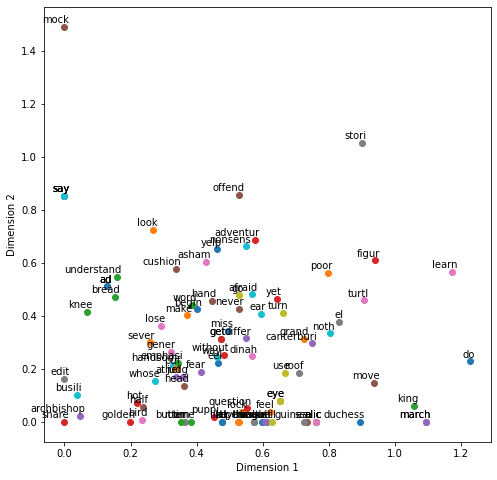

In [81]:
# In inches.
plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    x = xvals[i]
    y = yvals[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()